<h1 style=color:#023BFF><strong>Knapsack Problem, A Genetic Approach</strong></h1>

<h2 style=color:#63B8FF>Introduction</h2>
This notebook contains a solution to Knapsack problem with the help of genetic algorithm

<h3><mark> Adding libraries and Initializing global variables </mark></h3>
For the first step we have to include libraries that we are going to use further in the project.
We also need to initialize some hyper parameters to control the flow of our algorithm.

<div class="alert alert-block alert-info">
<b>Limitation of Solutions :</b> the first 4 parameters are given by the instructor (max weight, min value, range of different items to choose)</div>

<div class="alert alert-block alert-info">
<b>Population Settings :</b> population increase ratio can be set to determine whether the population increases over generations or stays the same (in terms of number) </div>

<div class="alert alert-block alert-info">
<b>Partitioning Ratio :</b> This floating number determines the best part to be chosen for mating/creation of each new generation</div>

<div class="alert alert-block alert-info">
<b>Mutation, Crossover :</b> Ratio of these are set to determines the probability of doing crossover, mutation or just simply forwarding the chromosome to the next generation</div>

In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import copy

maxWeight = 10
minValue = 12
maxDiversity = 4
minDiversity = 2

populationSize = 30
populationIncRatio = 1.00
numOfGenerations = 400

bestPartRatio = 0.5

crossoverRate = 0.85
mutationRate = 0.12

<h3 style=color:green><strong>Chromosome Creation</strong></h3>
<p style=font-family:Calibri>Chromosomes are solutions made by adding genomes (different weight of different items) together</p>
<p style=font-family:Calibri>the initialization of chromosome are completely random, then we have the getFitness which will return total sack value as fitness score if the limitation are met! </p>

<div class="alert alert-block alert-info">
<b>evalValue() :</b> recalculates sackValue (used when we change the sackWeight vector while using crossover/mutation)</div>

In [2]:
class Chromosome:
    def __init__(self, data, numOfItems):
        randomIndex = rd.sample(range(len(data)), numOfItems)
        sackWeight = [0 for _ in range(len(data))]
        sackValue = 0
        for i in randomIndex :
            chosenWeight = rd.uniform(0, data['Available Weight'][i])
            sackValue += (chosenWeight/data['Available Weight'][i]) * data['Value'][i]
            sackWeight[i] = chosenWeight
        self.sackVal = sackValue
        self.sackW = sackWeight


    def getFitness(self):
        global minValue, maxWeight

        if(self.sackVal < minValue or sum(self.sackW) > maxWeight):
            return 0
        else :
            return self.sackVal
        
        
    def evalValue(self, data):
        sackValue = 0
        for i in range(len(self.sackW)) :
            if(self.sackW[i]):
                sackValue += (self.sackW[i]/data['Available Weight'][i]) * data['Value'][i]
        self.sackVal = sackValue

<h3 style=color:purple> <strong>First Generation</strong></h3>
below you can find the function that generates the first population randomly with only considartion being the diversity of items used to create a chromosome

In [3]:
def generateInitialPopulation(data):
    global maxDiversity, minDiversity, populationSize

    initialPopulation = list()
    for i in range(populationSize):
        numOfItems = rd.randint(minDiversity, maxDiversity)
        initialPopulation.append(Chromosome(data, numOfItems))

    return initialPopulation

<h3 style=color:yellow> <strong>Selection </strong></h3>
Selection is done on the population with given Partition ratio (can be found in the first Cell) [usualy 0.5 or 0.25]

In [4]:
def selectBestPart(population, bestPartRatio):
    return sorted(population, key=lambda x : x.getFitness(), reverse=True)[0:int(len(population)* bestPartRatio)]

<h3 style=color:#FF0013> <strong>Crossover</strong> </h3>
<p style=font-family:Calibri>In this project I am using one-point crossover as it's easy to implement and understand (and results are good enough!)</p>
<div class="alert alert-block alert-info">
<b>Crossover vs. positiveCrossover :</b> the only difference between the two is that positiveCrossover tries it's best to avoide making a child that would get 0 as their fitness score (by checking the fitness before returning the child, altough it may still endup with a child that has 0 score)</div>

<div class="alert alert-block alert-success">
<b>Choice :</b> for the remaineder of this project normal crossover is used as it is more simple, but positiveCrossover has a correct functionality too and can replace crossover whereever it's used!
</div>

In [60]:
def crossover(data, parent1, parent2):
    global maxDiversity, minDiversity

    child = copy.deepcopy(parent1)
    accept = False
    while(accept == False):
        crossoverPoint = rd.randrange(0, len(data))
        child = copy.deepcopy(parent1)
        if(np.random.random() > 0.5):
            child.sackW[crossoverPoint:len(data)] = parent2.sackW[crossoverPoint:len(data)]
        else :
            child.sackW[0:crossoverPoint] = parent2.sackW[0:crossoverPoint]
        if(sum(x != 0 for x in child.sackW) >= minDiversity and sum(x != 0 for x in child.sackW) <= maxDiversity):
            accept = True
    child.evalValue(data)
    return child

def positiveCrossover(data, parent1, parent2):
    global minDiversity, maxDiversity

    child = copy.deepcopy(parent1)
    accept = False
    while(accept == False):
        crossoverPoint = rd.randrange(0, len(data))
        child = copy.deepcopy(parent1)
        child.sackW[crossoverPoint:len(data)] = parent2.sackW[crossoverPoint:len(data)]
        child.evalValue(data)
        if(child.getFitness() > 0):
            if(sum(x != 0 for x in child.sackW) >= minDiversity and sum(x != 0 for x in child.sackW) <= maxDiversity):
                accept = True
        else :
            child.sackW[crossoverPoint:len(data)] = parent1.sackW[crossoverPoint:len(data)]
            child.sackW[0:crossoverPoint] = parent2.sackW[0:crossoverPoint]
            if(sum(x != 0 for x in child.sackW) >= minDiversity and sum(x != 0 for x in child.sackW) <= maxDiversity):
                accept = True
    child.evalValue(data)
    return child

<h3 style=color:#FF0013> <strong>Mutation</strong> </h3>
<p style=font-family:Calibri>For this part some kind of bitFlip is used, as it will randomly choose one of the items possible in the genome, change its weight (again by a random amount) and re-evaluate the sack value</p>

<div class="alert alert-block alert-info">
<b>mutate vs. positiveMutate :</b> the only difference between the two is that positiveMutate tries it's best to avoide changing the choromosome in a way that would get its fitness score to 0 ! (by avoiding weight change of an item either because it was chosen wrongly or with going to be changed by a wrong amount)</div>

<div class="alert alert-block alert-success">
<b>Choice :</b> for the remaineder of this project normal mutatuib is used as it is more simple, but positiveMutate has a correct functionality too and can replace crossover whereever it's used!
</div>

In [6]:


def mutate(data, chromosome):
    notZeros = list()
    for i in range(len(chromosome.sackW)):
        if(chromosome.sackW[i] > 0):
            notZeros.append(i)
    mutationBit = rd.randrange(0, len(data))
    newZeroBit = rd.choice(notZeros)
    chromosome.sackW[mutationBit] = rd.uniform(0, data['Available Weight'][mutationBit])
    chromosome.sackW[newZeroBit] = 0
    chromosome.evalValue(data)
    return chromosome


def positiveMutate(data, chromosome):
    global maxWeight
    
    notZeros = list()
    for i in range(len(chromosome.sackW)):
        if(chromosome.sackW[i] > 0):
            notZeros.append(i)
    mutationBit = rd.randrange(0, len(data))
    newZeroBit = rd.choice(notZeros)
    mutationAmount = rd.uniform(0, data['Available Weight'][mutationBit])
    if(chromosome.getFitness() > 0):
        while((sum(chromosome.sackW) - chromosome.sackW[mutationBit] + mutationAmount) > maxWeight):
            mutationBit = rd.randrange(0, len(data))
            mutationAmount = rd.uniform(0, data['Available Weight'][mutationBit])
    chromosome.sackW[mutationBit] = mutationAmount
    chromosome.sackW[newZeroBit] = 0
    chromosome.evalValue(data)
    return chromosome



<h3 style=color:#FF8300> <strong>Evolution</strong> </h3>
with the help of Selection, Mutation and Crossover, we can evolve out poplution generation by generation.
for making a new generation we have to choose our best chromosomes (for example best half considering fitness score) and evolve a new generation around them, either by crossover, mutation or simply moving a copy of them to the next generation. Thi operation is done by giving a priority to each of crossover/mutation/forwarding (set at the first cell of the notebook)

<div class="alert alert-block alert-info">
<b>Forwarding :</b> when neither mutation or crossover is chosen, we simply copy a chromosome to the next generation (with more priority given to the better chromosome in terms of fitness score)</div>

In [7]:

def makeNextGeneration(data, pastGeneration):
    global crossoverRate, mutationRate, populationIncRatio, bestPartRatio

    newGeneration = list()
    bestPart = selectBestPart(pastGeneration, bestPartRatio)

    for _ in range(int(len(pastGeneration) * populationIncRatio)):
        choiceProb = np.random.random()

        if(choiceProb < crossoverRate):
            newGeneration.append(crossover(data, parent1= bestPart[rd.randrange(0, len(bestPart))],
                                            parent2= bestPart[rd.randrange(0, len(bestPart))]))
        elif(choiceProb < mutationRate + crossoverRate):
            newGeneration.append(mutate(data, pastGeneration[rd.randrange(0, len(bestPart))]))

        else :
            chances = list(range(len(bestPart), 0, -1))
            index = list(range(0, len(bestPart)))
            newGeneration.append(bestPart[rd.choices(index, chances, k=1)[0]])

    return newGeneration

<h3 style=color:brown> <strong>Running The Algorithm</strong> </h3>
In the first step we have to read the list of items provided in a CSV file with help of pandas library as a Dataframe
We also show the best solution in the first generation for more clarity
<div class="alert alert-block alert-info">
<b>Fitness history :</b> Best score and Mean of every generation is stored in a list for visualisation at a later stage</div>
<div class="alert alert-block alert-danger">
<b>FitnessList :</b> Only the top 80% of population's fitness score is stored, as the lower ones only cause fluctuation in our statistics and visualizations
</div>

In [161]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import copy

maxWeight = 80
minValue = 88.01
maxDiversity = 19
minDiversity = 18

populationSize = 50
populationIncRatio = 1.00
numOfGenerations = 2

bestPartRatio = 0.4

crossoverRate = 0.8
mutationRate = 0.1

In [170]:
snacks = pd.read_csv('snacks.csv')
population = generateInitialPopulation(snacks)
fitnessBestHistory = list()
fitnessMeanHistory = list()
fitnessList = [round(x.getFitness(), 4) for x in selectBestPart(population, 0.8)]
fitnessBestHistory.append(fitnessList[0])
fitnessMeanHistory.append(sum(fitnessList)/len(fitnessList))

output = "Best solution in the first generation (shown by weight) : \n"
bestHalf = selectBestPart(population, 0.5)
for i in range(len(bestHalf[0].sackW)):
    if(bestHalf[0].sackW[i] > 0):
        output += f"{snacks['Snack'][i]} -> {bestHalf[0].sackW[i]} \n"
output += f"Total value : {round(bestHalf[0].sackVal, 4)}"
print(output)


Best solution in the first generation (shown by weight) : 
MazMaz -> 2.515206446395487 
Doogh-e-Abali -> 4.174695368735656 
Nani -> 3.040854801674989 
Jooj -> 2.473386387064478 
Hot-Dog -> 8.997066649185303 
Chips -> 2.6796217238721036 
Nooshaba -> 9.42543147167332 
Shokolat -> 0.8722194619019186 
Chocoroll -> 3.182564711978109 
Abnabat -> 0.3825711680642674 
Adams-Khersi -> 2.323387445501828 
Popcorn -> 15.485338044343987 
Pastil -> 1.280490687143395 
Tordilla -> 6.640550314760276 
Masghati -> 0.20030511402748752 
Ghottab -> 5.788777968850194 
Saghe-Talaei -> 6.592401524123854 
Choob-Shoor -> 12.213835404585723 
Total value : 85.2055


__Now we have to evolve our population generation by generation (for a specific amount set at the first Cell)__

In [171]:
for i in range(numOfGenerations):
    population = makeNextGeneration(snacks, population)
    fitnessList = [round(x.getFitness(), 4) for x in selectBestPart(population, 0.8)]
    fitnessBestHistory.append(fitnessList[0])
    fitnessMeanHistory.append(sum(fitnessList)/len(fitnessList))

output = "Best solution in the last generation (shown by weight) : \n"
bestHalf = selectBestPart(population, 0.5)
for i in range(len(bestHalf[0].sackW)):
    if(bestHalf[0].sackW[i] > 0):
        output += f"{snacks['Snack'][i]} -> {bestHalf[0].sackW[i]} \n"
output += f"Total value : {round(bestHalf[0].sackVal, 4)}"
print(output)

Best solution in the last generation (shown by weight) : 
MazMaz -> 1.3149824359482054 
Doogh-e-Abali -> 12.082963246503548 
Nani -> 4.982940510096373 
Jooj -> 6.257932349147927 
Hot-Dog -> 4.870875542062882 
Chips -> 0.8279712034550544 
Nooshaba -> 9.777093018177212 
Shokolat -> 0.35341270168057837 
Chocoroll -> 4.9085852732254835 
Cookies -> 0.1293095592486183 
Adams-Khersi -> 5.76796952565351 
Popcorn -> 12.344404310289086 
Pastil -> 1.9686467412309931 
Tordilla -> 5.727267849870147 
Masghati -> 3.5370817832814545 
Ghottab -> 5.411966303558938 
Saghe-Talaei -> 4.204537908424813 
Choob-Shoor -> 6.540951066275058 
Total value : 92.2801


<h3 style=color:yellow> <strong>Visualisation</strong> </h3>
Simply visualizes the growth of best chromosome and the whole population after each new generation

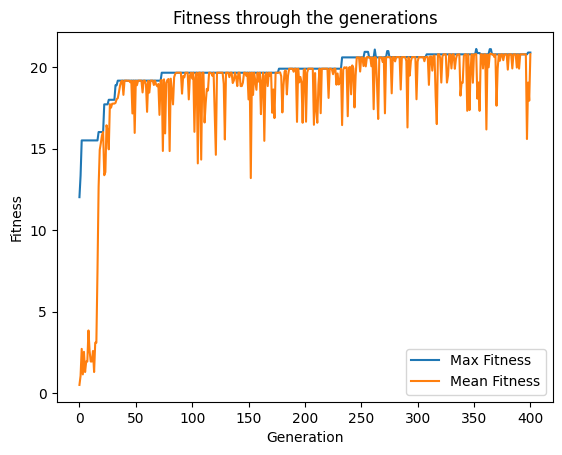

In [ ]:
plt.plot(list(range(numOfGenerations+1)), fitnessBestHistory, label='Max Fitness')
plt.plot(list(range(numOfGenerations+1)), fitnessMeanHistory, label='Mean Fitness')
plt.legend()
plt.title('Fitness through the generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.show()

<h2><strong>Homework Questions : </strong><h2>
<img src="questions.png" />

1.  1. <p> <strong> Too small initial population  -> </strong>limiting search space resulting in premature convergence to suboptimal solutions, too much sensitivity to initial conditions (ex. max weight or min value) </p>
    2. <p><strong>Too large initial population -> </strong>more computational resources needed, might result in slower than expected convergence because of how close each solution is to the others, The Law of Diminishing returns</p>
2. 1. <p><strong>Speed -> </strong>It will drastically as the population will increase exponentially </p>
    2. <p><strong>Accuracy -> </strong>It usually helps the accuracy because of three main reasons. First, a growing population increases the search space and helps with exploration. Second, by continuously adding new individuals to the population we reduced the chance of convergence to a suboptimal solution, and Third, the growing population can make algorithm resiliant to sudden changes and shifts (sometimes caused by bad mutations)  </p>
3. <p> While <strong>crossover </strong>tries to exploit already existing good features,<strong> mutation </strong>tries to find new possibilities in the search space. one might argue that by only exploiting good features and combining better chromosomes we can find the best solution, but In the real world the <strong>initial population </strong>might have no good feature at all (ex. a population that all the chromosomes get zero fitness score), or the search space might limit you to Its suboptimal solution, that's when mutation can help to find solutions never seen before.</p>
4. 1. Parallelization
    2. Different mutation or crossover methods (ex. two-point crossover)
    3. Early convergence detection (so the operation can terminate if it detects no difference in newer generations)
    4. Dynamicly changing population size, mutation rate or crossover rate based on the model's performance
5.  <p>Some reasons for <strong>Stagnation </strong>: </p>
    1. Lack of diversity in initial/current population (might be caused by bad conditions or just randomly generated)<p></p>
    2. Convergence to a local optimum due to lack of decent exploration strategies<p></p>
    3. Static environment
    <p>Solutions : </p>
    1. Increasing parameters like mutation rate to increase diversity<p></p>
    2. Dynamic adaptation such as chaning mutation/crossover rate over time
    <p></p>
6. 1. Tracking locality of answers, if there seems to be no convergence after some time, we could conclude that there is no answer
    2. Re-evaluate fitness calculation
    3. Change crossover/mutation strategies
    

<h4 style=color:#63B8FF><mark>Name : Alireza Hosseini <br>Student ID : 810100125</mark> </h4>



<h5 style=color:#C900C0> References </h5>
<a href="https://medium.com/koderunners/genetic-algorithm-part-3-knapsack-problem-b59035ddd1d6" target="_blank">Genetic Algorithm: Part 3 — Knapsack Problem</a><br>
<a href="https://www.kaggle.com/code/cuecacuela/the-ultimate-markdown-cheat-sheet/notebook#3.-Links" target="_blank">The Ultimate Markdown Cheat Sheet</a><br>
<div class="alert alert-block alert-danger">
<b>Use of ChatBots :</b>  OpenAI's ChatGPT and Google's Gemini have been used to further understand the genetic algorithm, use of different libraries and get some ideas about Homework Questions, but no piece of code or text has been directly quoted/copied from them.
</div>
